### CycleGAN
In this notebook we are going to pick anather dataset from [tensorflow datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan) and have a closer look on cyclegan. This notebook will be similar from the [previous notebook](https://github.com/CrispenGari/keras-api/blob/main/13_Unsupervised_L/03_CycleGAN/01_Introduction_From_Tensorflow_Tutorial.ipynb)

In this notebook we are going to use [tensorflow_example]() packege to import pix2pix gerator and discriminator model. We are not going to build discriminators and generators from scretch all we have to do is to install tensorflow example as follows:
```
!pip install git+https://github.com/tensorflow/examples.git
```

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

### Imports 

In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os, time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from prettytable import PrettyTable

AUTOTUNE = tf.data.AUTOTUNE

tf.__version__

'2.5.0'

### Input pipeline.

In this notebook we are going to translate images from `summer2winter` dataset which you can find [here](https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_gansummer2winter_yosemite).

Again we are going to perform some preprocessing on our datasets which include.

* ``random jittering``, the image is resized to ``286 x 286`` and then randomly cropped to ``256 x 256``.
* ``random mirroring``, the image is randomly flipped horizontally i.e left to right.
* We are going to normalize the image so that each pixel value will be in range ``[-1, 1]``.

### Loadingthe data.

In [ ]:
dataset, metadata = tfds.load(
    'cycle_gan/summer2winter_yosemite',
    with_info=True,
    as_supervised=True
)

train_summer_images, train_winter_images = dataset["trainA"], dataset["trainB"]
test_summer_images, test_winter_images = dataset["testA"], dataset["testB"]


### Hyper params

In [6]:
BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Random cropping

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3]
  )
  return cropped_image

### Normalizing images

In [8]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

### Random ``jittering``

In [9]:
def random_jitter(image):
  image = tf.image.resize(image,[286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
                          )
  image = random_crop(image)
  image = tf.image.random_flip_left_right(image)
  return image

### Preprocessing functions

**Note:** - During image processing we wre only applying `random_jitter` to the train set. In the test set we only need to normalize images.

In [10]:
def process_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def process_image_test(image, label):
  return normalize(image)

In [11]:
train_summer = train_summer_images.cache().map(
     process_image_train, num_parallel_calls=AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_winter = train_winter_images.cache().map(
     process_image_train, num_parallel_calls=AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_summer = test_summer_images.cache().map(
     process_image_test, num_parallel_calls=AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_winter = test_winter_images.cache().map(
     process_image_test, num_parallel_calls=AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Examples.


In [13]:
colums_data = "SUBSET", "EXAMPLE(s)"
rows_data = [
             ["training(summer)", f'{len(train_summer):,}'], 
             ["training(winter)", f'{len(train_winter):,}'],
             ["testing(summer)", f'{len(test_summer):,}'], 
             ["testing(winter)", f'{len(test_winter):,}'],
  ]
title = "TOTAL EXAMPLES FOR ALL SUBSETS"
def tabulate_example(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)
tabulate_example(colums_data, rows_data, title)

+---------------------------------+
|  TOTAL EXAMPLES FOR ALL SUBSETS |
+-------------------+-------------+
| SUBSET            |  EXAMPLE(s) |
+-------------------+-------------+
| training(summer)  |       1,231 |
| training(winter)  |         962 |
| testing(summer)   |         309 |
| testing(winter)   |         238 |
+-------------------+-------------+


In [20]:
sample_summer = next(iter(train_summer ))
sample_winter = next(iter(train_winter ))

### Checking an image.

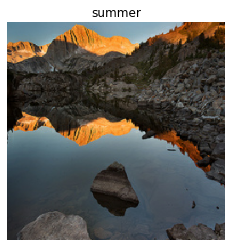

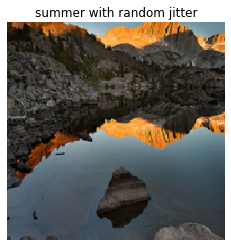

In [21]:
plt.imshow(sample_summer[0] * 0.5 + 0.5, cmap="gray")
plt.title("summer")
plt.axis('off')
plt.show()

plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5, cmap="gray")
plt.title("summer with random jitter")
plt.axis('off')
plt.show()

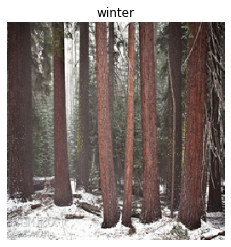

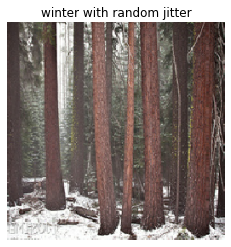

In [22]:
plt.imshow(sample_winter[0] * 0.5 + 0.5, cmap="gray")
plt.title("winter")
plt.axis('off')
plt.show()

plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5, cmap="gray")
plt.title("winter with random jitter")
plt.axis('off')
plt.show()

### Next
We will import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this notebook is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN](https://arxiv.org/abs/1703.10593) paper uses a modified resnet based generator. This notebook is using a modified unet generator for simplicity.
There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

Generator G learns to transform image X to image Y. $(G: X -> Y)$
Generator F learns to transform image Y to image X. $(F: Y -> X)$
Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

![](https://camo.githubusercontent.com/e81af8c74b9b425d70c32e6c10f2b61342e472df/68747470733a2f2f6769746875622e636f6d2f74656e736f72666c6f772f646f63732f626c6f622f6d61737465722f736974652f656e2f7475746f7269616c732f67656e657261746976652f696d616765732f6379636c6567616e5f6d6f64656c2e706e673f7261773d31)


In [26]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, None, None, 6 3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, None, None, 1 131328      sequential_15[0][0]              
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, None, None, 2 524800      sequential_16[0][0]              
____________________________________________________________________________________________

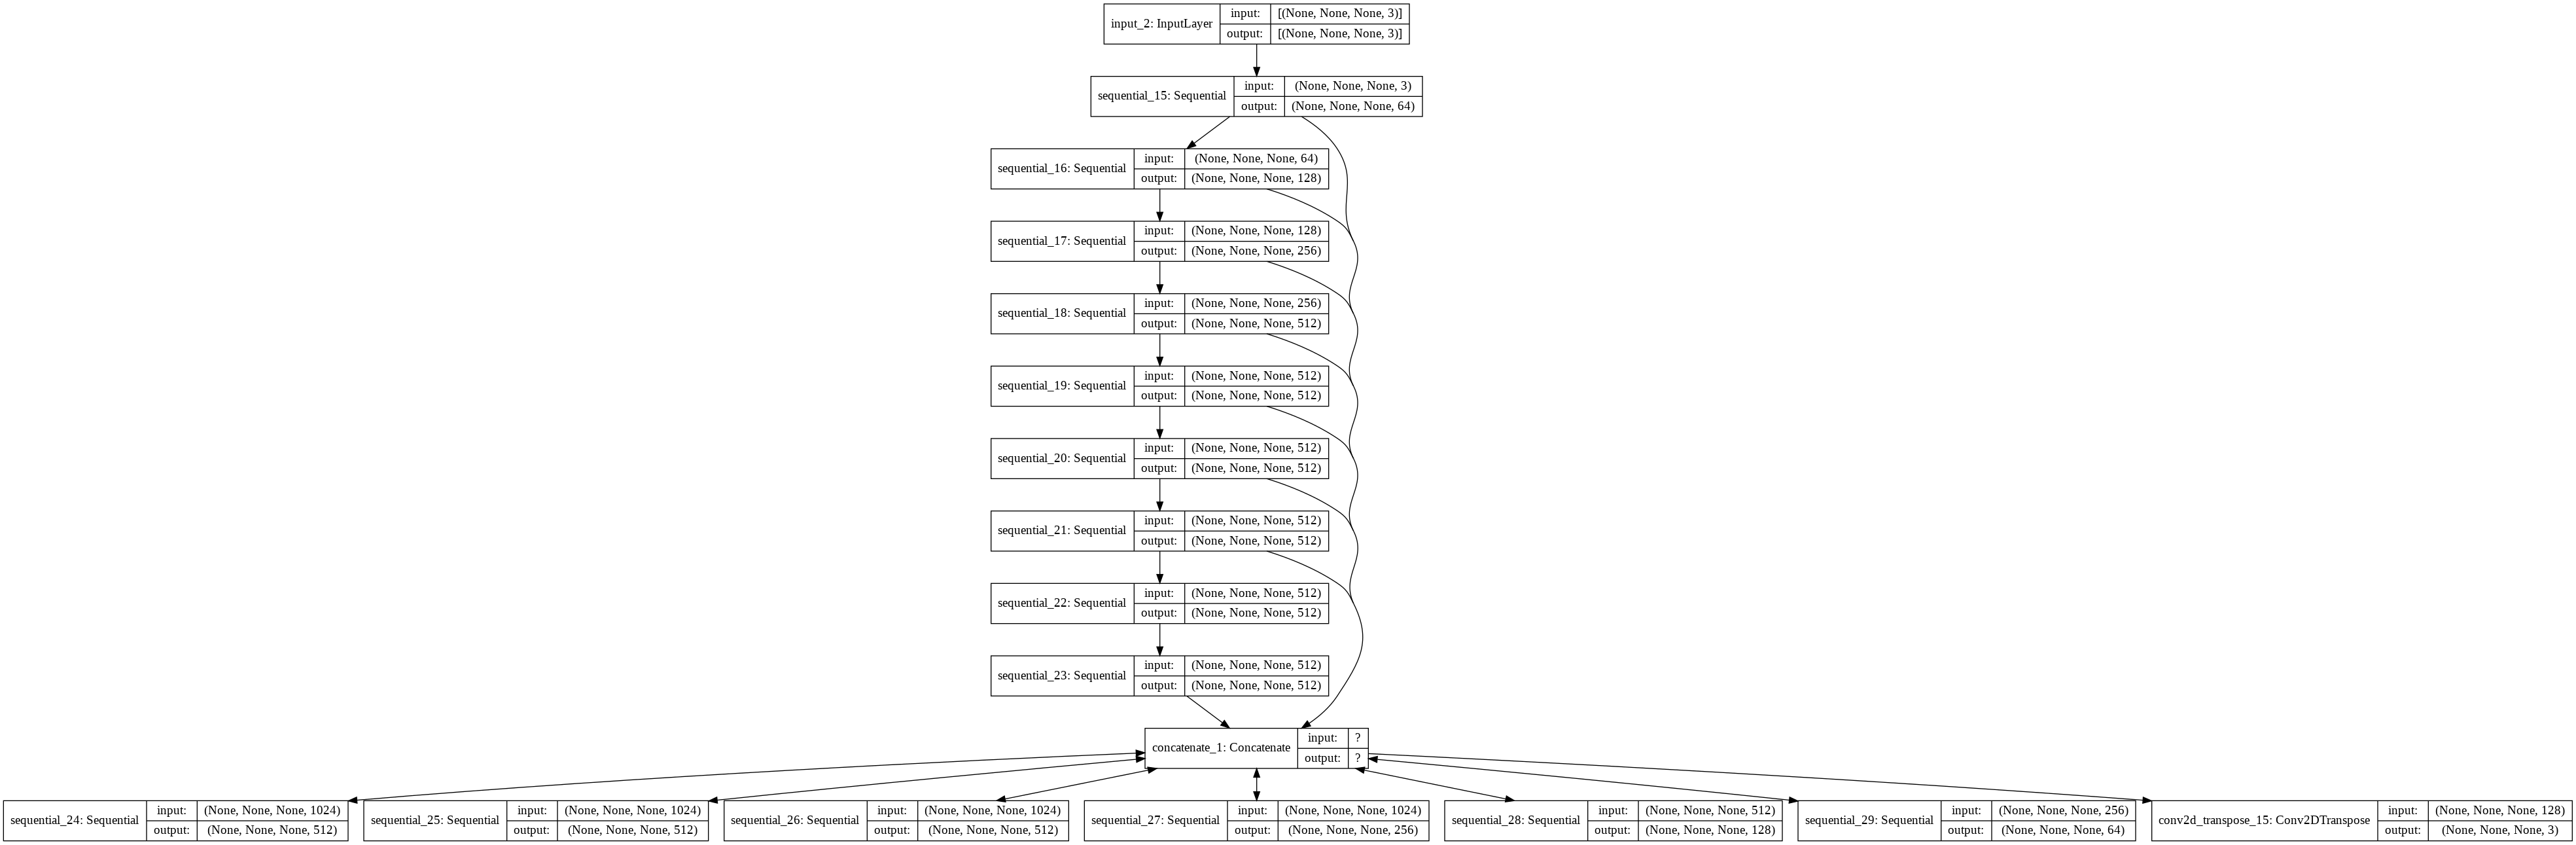

In [31]:
print(generator_f.summary())
keras.utils.plot_model(generator_f, show_shapes=True,dpi=96 )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_30 (Sequential)   (None, None, None, 64)    3072      
_________________________________________________________________
sequential_31 (Sequential)   (None, None, None, 128)   131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 256)   0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_30 (I (None, None, None, 512)   1024

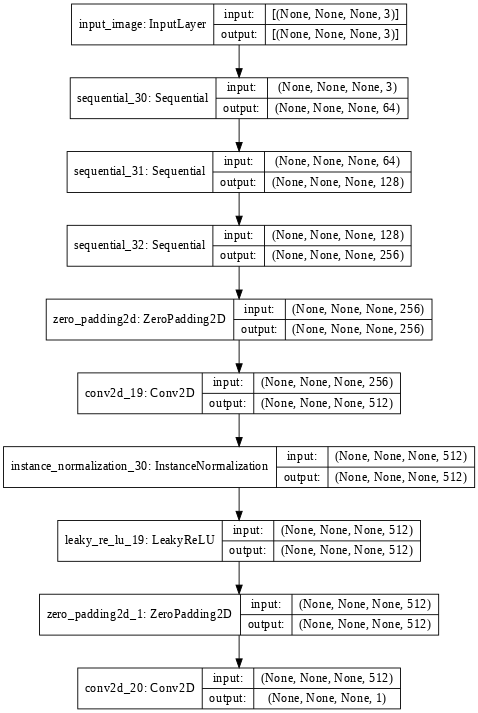

In [37]:
print(discriminator_x.summary())
keras.utils.plot_model(discriminator_x, show_shapes=True,dpi=64 )

### Testing the generators models.

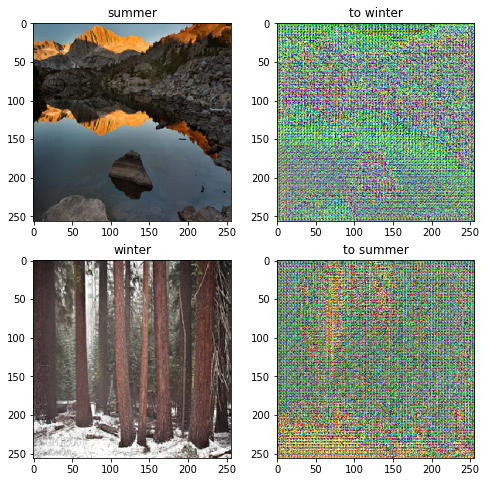

In [38]:

to_winter = generator_g(sample_summer)
to_summer = generator_f(sample_winter)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ['summer', 'to winter', 'winter', 'to summer']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

### Testing the discriminator

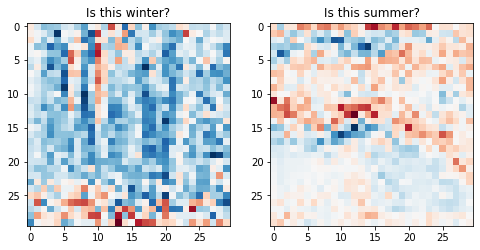

In [39]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is this winter?')
plt.imshow(discriminator_y(sample_winter)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is this summer?')
plt.imshow(discriminator_x(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss functions.

In ``CycleGAN``, there is no paired data to train on, hence there is no guarantee that the input ``x`` and the target ``y`` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in ``pix2pix``.

In [40]:
LAMBDA = 10
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [41]:
def discriminator_loss(real, generated):
  real_loss = criterion(tf.ones_like(real), real)
  fake_loss = criterion(tf.zeros_like(generated), generated)
  return (fake_loss + real_loss) * .5 


def generator_loss(generated):
  loss = criterion(tf.ones_like(generated), generated)
  return loss

> Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.
$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$

![](https://camo.githubusercontent.com/09ad51cb39ba10e7736130e07e4517baa9d615fd/68747470733a2f2f6769746875622e636f6d2f74656e736f72666c6f772f646f63732f626c6f622f6d61737465722f736974652f656e2f7475746f7269616c732f67656e657261746976652f696d616765732f6379636c655f6c6f73732e706e673f7261773d31)

In [42]:
def cal_cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [43]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * .5 * loss

### Optimizers.
We are going to create our optimizers for both our generators and discriminators. We are going to use the same optimizer typically Adam with ``learning rate = 2e-4 and beta_1 = .5``.

In [45]:
generator_g_optimizer = generator_f_optimizer = keras.optimizers.Adam(
    2e-4, beta_1 = .5
)

discriminator_x_optimizer = discriminator_y_optimizer = keras.optimizers.Adam(
      2e-4, beta_1 = .5
)

### Checkpoints

In [46]:

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Training

We are going to train this model with fewer epochs to keep training time reasonable since we are just doing this for practice.

 **I recommend training for more epochs to get better results.**

In [47]:
EPOCHS =20

In [48]:
sample_winter

TensorShape([1, 256, 256, 3])

In [49]:
def generated_images(model, test_input):
  prediction = model(test_input)
  plt.figure(figsize=(8, 8))
  display_list = [test_input[0], prediction[0]]
  title = ['input image', 'generated image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

We have two inputs (X) and (Y) and two generators (G) and (F)

```py

## Generator G translates X -> Y
    
[x] ------> [  G  ] -----> [Y]
                            |
[x] <------ [  F  ] <------[Y]

## Generator F translates Y -> X

[y] ------> [  F  ] -----> [X]
                            |
[y] <------ [  G  ] <------[X]
```


In [55]:
tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    """
    Generator G translates X -> Y
    Generator F translates Y -> X.
    """
    fake_y = generator_g(real_x, training=True)
    cycled_y = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_x = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    """
    calculating the losses
    """
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cyled_loss = cal_cycle_loss(
        real_x, cycled_x
    ) + cal_cycle_loss(
         real_y, cycled_y
    )
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cyled_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cyled_loss + identity_loss(real_x, same_y)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  ## Calculating the gradients and updating the weights

  gradients_of_generator_g = tape.gradient(
      total_gen_g_loss, generator_g.trainable_variables
  )
  gradients_of_generator_f = tape.gradient(
      total_gen_f_loss, generator_f.trainable_variables
  )

  gradients_of_discriminator_x = tape.gradient(
      disc_x_loss, discriminator_x.trainable_variables
  )
  gradients_of_discriminator_y = tape.gradient(
      disc_y_loss, discriminator_y.trainable_variables
  )

  generator_g_optimizer.apply_gradients(zip(
      gradients_of_generator_g, generator_g.trainable_variables
  ))
  generator_f_optimizer.apply_gradients(zip(
      gradients_of_generator_f, generator_f.trainable_variables
  ))

  discriminator_x_optimizer.apply_gradients(zip(
      gradients_of_discriminator_x, discriminator_x.trainable_variables
  ))
  discriminator_y_optimizer.apply_gradients(zip(
      gradients_of_discriminator_y, discriminator_y.trainable_variables
  ))
  return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss


### Helper functions for the training loop.
1. time to string

In [56]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

2. tabulate training epoch

In [57]:
def tabulate_training_epochs(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  table.align[column_names[4]] = 'r'
  table.align[column_names[5]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [58]:
def fit(train_summer, train_winter, epochs):
  columns_data =["EPOCH", "ETA", "GEN_G_LOSS", "GEN_F_LOSS", "DISC_X_LOSS","DISC_Y_LOSS"]
  print("Training start....")
  for epoch in range (epochs):
    start = time.time()
    n = 0
    gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = 0, 0, 0, 0
    for image_x, image_y in tf.data.Dataset.zip((train_summer, train_winter)):
      g_loss, f_loss, x_loss, y_loss = train_step(image_x, image_y)

      gen_g_loss += g_loss
      gen_f_loss += f_loss
      disc_x_loss += x_loss
      disc_y_loss += y_loss
      n += 1
    end = time.time()
    if (epoch + 1) % 10 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))
    rows_data = [
       [epoch+1, hms_string(end - start),
        f'{(gen_g_loss/n):.3f}',
        f'{(gen_f_loss/n):.3f}',
        f'{(disc_x_loss/n):.3f}',
        f'{(disc_y_loss/n):.3f}'
        ],      
    ]
    title = f'EPOCH:  {epoch+1:02}/{epochs} {"display" if epoch == 0 or (epoch+1)%10 == 0 else "no display"}'
    if epoch == 0 or (epoch+1) % 10 == 0:
      # Using a consistent image (sample_summer) so that the progress of the model is clearly visible.
      generated_images(generator_g, sample_summer)

    tabulate_training_epochs(columns_data, rows_data, title)

### Running the training loop.

Training start....


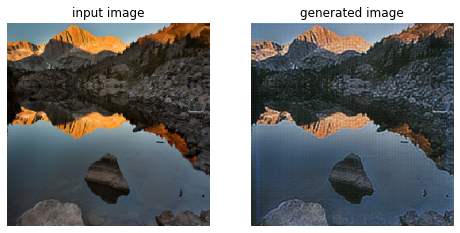

+--------------------------------------------------------------------------+
|                          EPOCH:  01/20 display                           |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 1     | 0:17:01.67 |      0.809 |      0.889 |       0.652 |       0.687 |
+-------+------------+------------+------------+-------------+-------------+


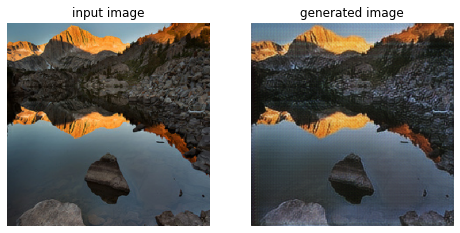

+--------------------------------------------------------------------------+
|                         EPOCH:  02/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 2     | 0:16:55.47 |      0.761 |      0.889 |       0.645 |       0.686 |
+-------+------------+------------+------------+-------------+-------------+


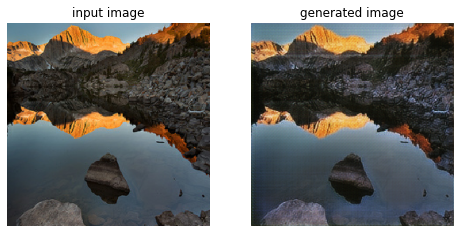

+--------------------------------------------------------------------------+
|                         EPOCH:  03/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 3     | 0:16:54.78 |      0.757 |      0.801 |       0.674 |       0.683 |
+-------+------------+------------+------------+-------------+-------------+


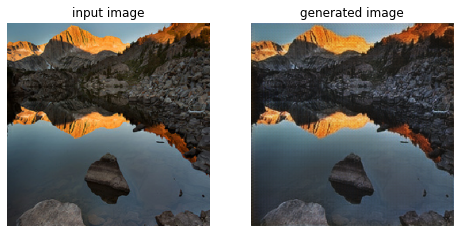

+--------------------------------------------------------------------------+
|                         EPOCH:  04/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 4     | 0:16:51.96 |      0.763 |      0.774 |       0.678 |       0.682 |
+-------+------------+------------+------------+-------------+-------------+


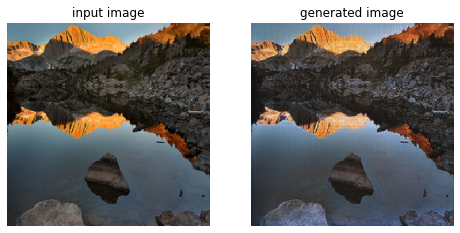

+--------------------------------------------------------------------------+
|                         EPOCH:  05/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 5     | 0:16:51.75 |      0.770 |      0.775 |       0.674 |       0.676 |
+-------+------------+------------+------------+-------------+-------------+


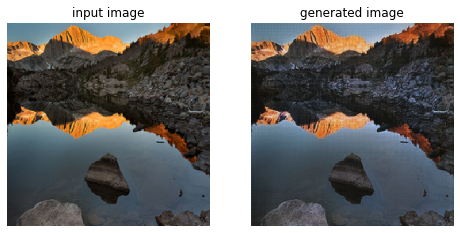

+--------------------------------------------------------------------------+
|                         EPOCH:  06/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 6     | 0:16:51.40 |      0.774 |      0.810 |       0.670 |       0.675 |
+-------+------------+------------+------------+-------------+-------------+


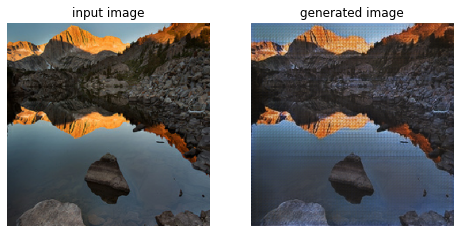

+--------------------------------------------------------------------------+
|                         EPOCH:  07/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 7     | 0:16:52.81 |      0.777 |      0.851 |       0.651 |       0.673 |
+-------+------------+------------+------------+-------------+-------------+


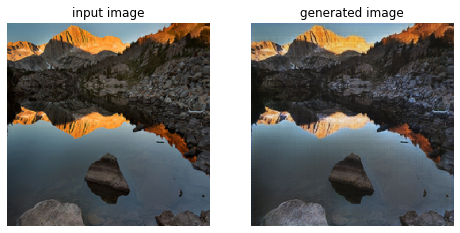

+--------------------------------------------------------------------------+
|                         EPOCH:  08/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 8     | 0:16:51.06 |      0.785 |      0.784 |       0.675 |       0.667 |
+-------+------------+------------+------------+-------------+-------------+


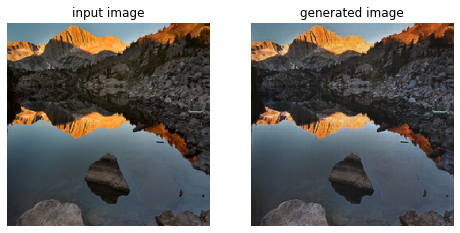

+--------------------------------------------------------------------------+
|                         EPOCH:  09/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 9     | 0:16:51.02 |      0.777 |      0.747 |       0.688 |       0.675 |
+-------+------------+------------+------------+-------------+-------------+
Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-1
+--------------------------------------------------------------------------+
|                          EPOCH:  10/20 display                           |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 10    | 0:16:

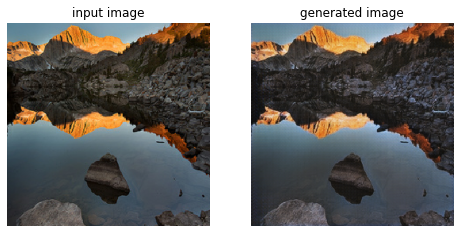

+--------------------------------------------------------------------------+
|                         EPOCH:  11/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 11    | 0:16:53.77 |      0.784 |      0.772 |       0.677 |       0.670 |
+-------+------------+------------+------------+-------------+-------------+


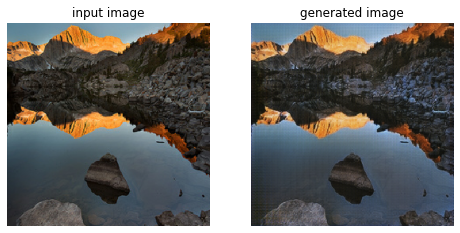

+--------------------------------------------------------------------------+
|                         EPOCH:  12/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 12    | 0:16:58.13 |      0.799 |      0.791 |       0.672 |       0.661 |
+-------+------------+------------+------------+-------------+-------------+


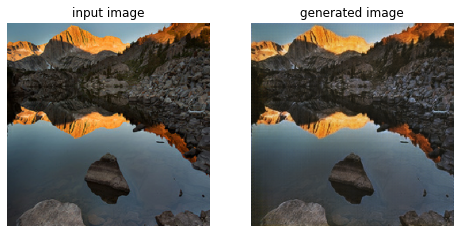

+--------------------------------------------------------------------------+
|                         EPOCH:  13/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 13    | 0:17:21.97 |      0.778 |      0.776 |       0.677 |       0.674 |
+-------+------------+------------+------------+-------------+-------------+


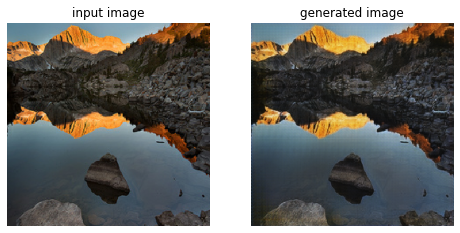

+--------------------------------------------------------------------------+
|                         EPOCH:  14/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 14    | 0:16:56.48 |      0.772 |      0.758 |       0.679 |       0.672 |
+-------+------------+------------+------------+-------------+-------------+


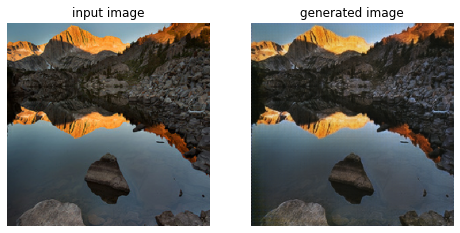

+--------------------------------------------------------------------------+
|                         EPOCH:  15/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 15    | 0:16:58.56 |      0.771 |      0.763 |       0.677 |       0.673 |
+-------+------------+------------+------------+-------------+-------------+


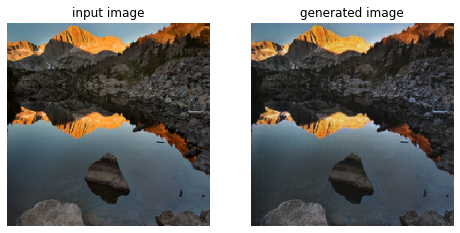

+--------------------------------------------------------------------------+
|                         EPOCH:  16/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 16    | 0:16:58.05 |      0.790 |      0.795 |       0.668 |       0.663 |
+-------+------------+------------+------------+-------------+-------------+


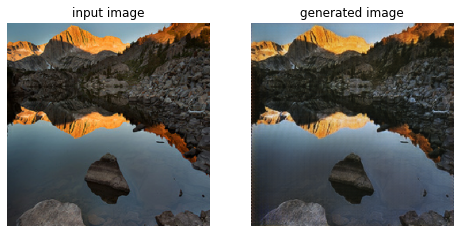

+--------------------------------------------------------------------------+
|                         EPOCH:  17/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 17    | 0:16:59.19 |      0.790 |      0.771 |       0.676 |       0.665 |
+-------+------------+------------+------------+-------------+-------------+


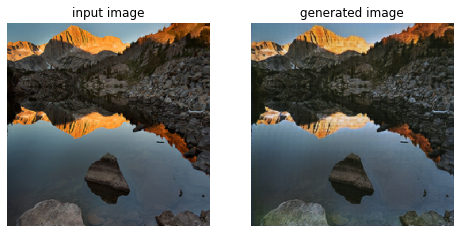

+--------------------------------------------------------------------------+
|                         EPOCH:  18/20 no display                         |
+-------+------------+------------+------------+-------------+-------------+
| EPOCH |        ETA | GEN_G_LOSS | GEN_F_LOSS | DISC_X_LOSS | DISC_Y_LOSS |
+-------+------------+------------+------------+-------------+-------------+
| 18    | 0:16:58.15 |      0.770 |      0.784 |       0.669 |       0.673 |
+-------+------------+------------+------------+-------------+-------------+


In [ ]:
fit(train_summer, train_winter, EPOCHS)

### Generating some images from the ``train`` set.

In [ ]:
for inp in train_summer.take(5):
  generate_images(generator_g, inp)

#### Generating images from the `test` set.

In [ ]:
for inp in test_summer.take(5):
  generate_images(generator_g, inp)

### Next 
We are going to build the generator and discriminator from skretch.